In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import pandas as pd
import copy

from sklearn.metrics import roc_curve , roc_auc_score , precision_recall_curve

pd.options.display.max_rows = 200

# Import Models and Test Data

In [2]:
rf = pickle.load(open('rf_os_final.p','rb'))
gb = pickle.load(open('gb_os_final.p','rb'))
logit= pickle.load(open('logRegModel_os.p','rb'))
vote_hard = pickle.load(open('voting_classifer_hard.p','rb'))
vote_soft = pickle.load(open('voting_classifer_soft.p','rb'))

In [3]:
X_val = pickle.load(open('X_val_processed.p','rb'))
y_val = pickle.load(open('y_val.p','rb'))
X_test = pickle.load(open('X_test_processed.p','rb'))
y_test = pickle.load(open('y_test.p','rb'))


In [51]:
y_val.shape

(1069,)

# Build a ROC curve

In [4]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val,rf.predict_proba(X_val)[:,1])
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_val,gb.predict_proba(X_val)[:,1])
logit_fpr, logit_tpr, logit_thresholds = roc_curve(y_val,logit.predict_proba(X_val)[:,1])
vote_soft_fpr, vote_soft_tpr, vote_soft_thresholds = roc_curve(y_val,vote_soft.predict_proba(X_val)[:,1])



roc_auc_rf = roc_auc_score(y_val,rf.predict_proba(X_val)[:,1])
roc_auc_gb = roc_auc_score(y_val,gb.predict_proba(X_val)[:,1])
roc_auc_logistic = roc_auc_score(y_val,logit.predict_proba(X_val)[:,1])
roc_auc_vote_soft = roc_auc_score(y_val,vote_soft.predict_proba(X_val)[:,1])



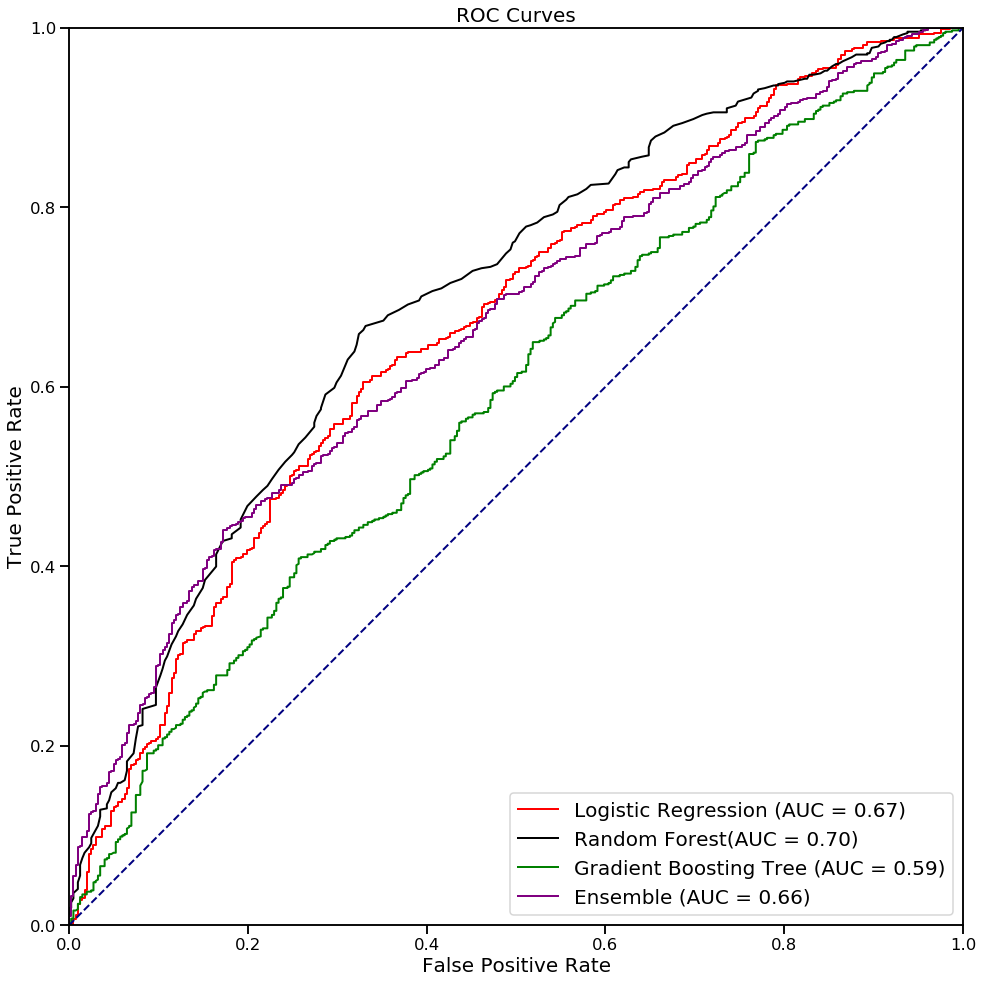

In [5]:
sns.set_context("talk")
fig = plt.figure(figsize=(14,14))
lw = 2


plt.plot(logit_fpr, logit_tpr, color='red',
         lw=lw, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logistic)
plt.plot(rf_fpr, rf_tpr, color='black',
         lw=lw, label='Random Forest(AUC = %0.2f)' % roc_auc_rf)
plt.plot(gb_fpr, gb_tpr, color='green',
         lw=lw, label='Gradient Boosting Tree (AUC = %0.2f)' % roc_auc_gb)
plt.plot(vote_soft_fpr,vote_soft_tpr, color='purple',
         lw=lw, label='Ensemble (AUC = %0.2f)' % roc_auc_vote_soft)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('ROC Curves', fontsize = 20)
plt.legend(loc="lower right", fontsize = 20)
plt.tight_layout()
# plt.savefig('roc_curves_all_ALL.png')
# plt.savefig('roc_curves_svg_all_all.svg')
plt.show()

# Build a PR curve

In [6]:
rf_percision, rf_recall, rf_thresholds = precision_recall_curve(y_val,rf.predict_proba(X_val)[:,1])
gb_percision, gb_recall, gb_thresholds = precision_recall_curve(y_val,gb.predict_proba(X_val)[:,1])
logit_percision, logit_recall, logit_thresholds = precision_recall_curve(y_val,logit.predict_proba(X_val)[:,1])
vote_soft_percision, vote_soft_recall, vote_soft_thresholds = precision_recall_curve(y_val,vote_soft.predict_proba(X_val)[:,1])




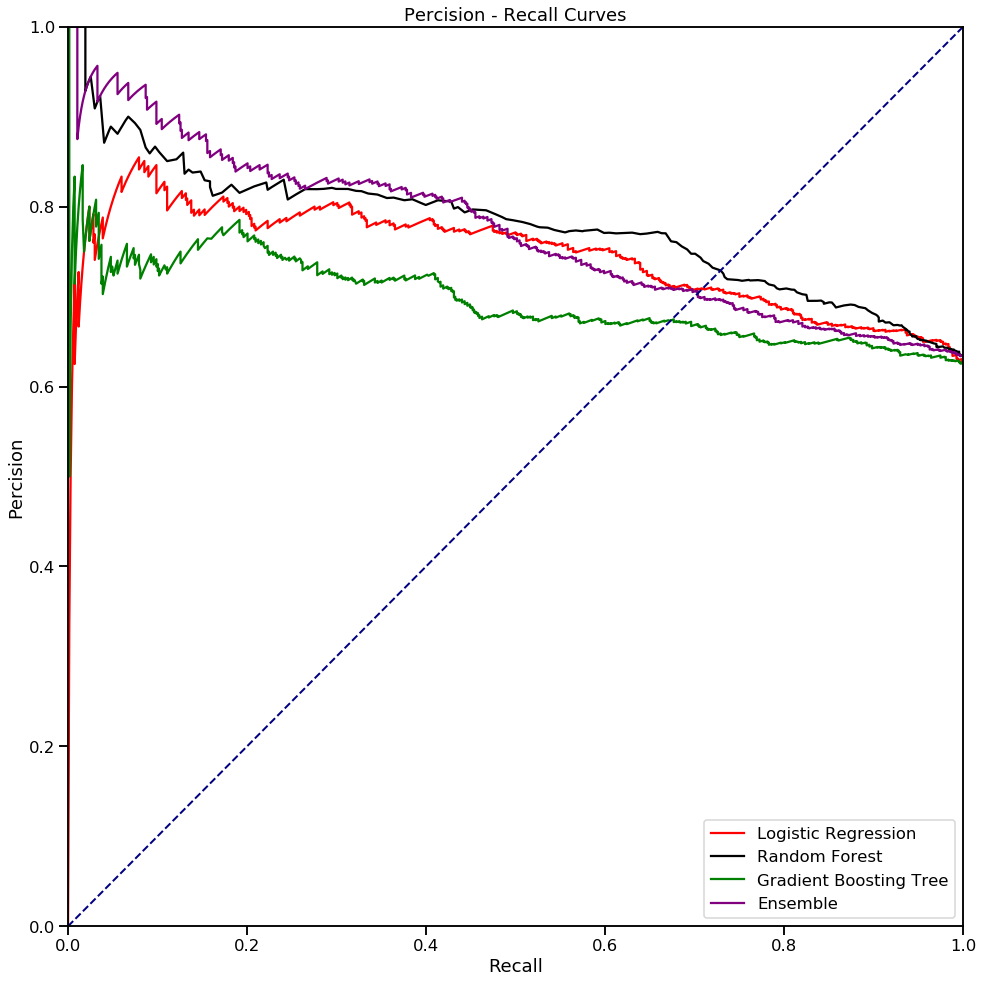

In [7]:
sns.set_context('talk')
fig = plt.figure(figsize=(14,14))



plt.plot( logit_recall,logit_percision, color='red',
          label='Logistic Regression')
plt.plot( rf_recall,rf_percision, color='black',
          label='Random Forest')
plt.plot( gb_recall,gb_percision, color='green',
          label='Gradient Boosting Tree')
plt.plot( vote_soft_recall,vote_soft_percision, color='purple',
          label='Ensemble')



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Percision')
plt.title('Percision - Recall Curves')
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig('roc_curves_all_ALL.png')
# plt.savefig('roc_curves_svg_all_all.svg')
plt.show()

# Threshold Tuning 

In [32]:
threshold_tuner = pd.DataFrame({
    'y_val':y_val,
    'rf_prob':rf.predict_proba(X_val)[:,1],
    'gb_prob':gb.predict_proba(X_val)[:,1],
    'logit_prob':logit.predict_proba(X_val)[:,1],
    'ensemble_prob':vote_soft.predict_proba(X_val)[:,1]
})

In [33]:
threshold_tuner['threshold'] = 0 
threshold_tuner_exploded = pd.DataFrame(columns = threshold_tuner.columns)


for n in range(101):
    threshold_tuner['threshold'] = n/100
    threshold_tuner_exploded=threshold_tuner_exploded.append(threshold_tuner,ignore_index=True)

In [34]:

threshold_tuner_exploded['rf_fp'] = 0
threshold_tuner_exploded['rf_fn'] = 0



threshold_tuner_exploded['gb_fp'] = 0
threshold_tuner_exploded['gb_fn'] = 0



threshold_tuner_exploded['logit_fp'] = 0
threshold_tuner_exploded['logit_fn'] = 0



threshold_tuner_exploded['ensemble_fp'] = 0
threshold_tuner_exploded['ensemble_fn'] = 0


In [35]:
threshold_tuner_exploded.sample(20)

,y_val,rf_prob,gb_prob,logit_prob,ensemble_prob,threshold,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn
25957,1,0.554,0.999732,0.964308,0.853313,0.24,0,0,0,0,0,0,0,0
62685,0,0.596,0.004552,0.981297,0.520019,0.58,0,0,0,0,0,0,0,0
9821,1,0.448,0.009513,0.136006,0.339360,0.09,0,0,0,0,0,0,0,0
81275,0,0.432,0.994357,0.033810,0.471059,0.76,0,0,0,0,0,0,0,0
24254,1,0.548,0.995208,0.038398,0.530539,0.22,0,0,0,0,0,0,0,0
14328,1,0.548,0.991619,0.198938,0.563902,0.13,0,0,0,0,0,0,0,0
80540,1,0.530,0.015897,0.159731,0.279868,0.75,0,0,0,0,0,0,0,0
35652,0,0.582,0.000748,0.010329,0.187790,0.33,0,0,0,0,0,0,0,0
48123,0,0.498,0.046207,0.174104,0.292365,0.45,0,0,0,0,0,0,0,0
13690,0,0.572,0.999751,0.123936,0.553835,0.12,0,0,0,0,0,0,0,0


In [36]:
tte=copy.deepcopy(threshold_tuner_exploded)

In [37]:
tte.loc[(tte.rf_prob>tte.threshold) & tte.y_val==0, 'rf_fp'] = int(1)
tte.loc[(tte.gb_prob>tte.threshold) & tte.y_val==0, 'gb_fp'] = int(1)
tte.loc[(tte.logit_prob>tte.threshold) & tte.y_val==0, 'logit_fp'] = int(1)
tte.loc[(tte.ensemble_prob>tte.threshold) & tte.y_val==0, 'ensemble_fp'] = int(1)

tte.loc[(tte.rf_prob<tte.threshold) & tte.y_val==1, 'rf_fn'] = int(1)
tte.loc[(tte.gb_prob<tte.threshold) & tte.y_val==1, 'gb_fn'] = int(1)
tte.loc[(tte.logit_prob<tte.threshold) & tte.y_val==1, 'logit_fn'] = int(1)
tte.loc[(tte.ensemble_prob<tte.threshold) & tte.y_val==1, 'ensemble_fn'] = int(1)

In [38]:
tte.head()

,y_val,rf_prob,gb_prob,logit_prob,ensemble_prob,threshold,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn
0,0,0.692,0.017427,0.367676,0.482324,0.0,1,0,1,0,1,0,1,0
1,1,0.732,0.999386,0.775281,0.831297,0.0,0,0,0,0,0,0,0,0
2,1,0.590,0.999678,0.565786,0.719381,0.0,0,0,0,0,0,0,0,0
3,0,0.340,0.000202,0.003413,0.118546,0.0,1,0,1,0,1,0,1,0
4,1,0.644,0.999752,0.667271,0.779470,0.0,0,0,0,0,0,0,0,0


In [58]:
tte['rf_cost'] = tte['rf_fp'] * 150000/2 + tte['rf_fn']*8000
tte['gb_cost'] = tte['gb_fp'] * 150000/2 + tte['gb_fn']*8000
tte['ensemble_cost'] = tte['ensemble_fp'] * 150000/2 + tte['ensemble_fn']*8000
tte['logit_cost'] = tte['logit_fp'] * 150000/2 + tte['logit_fn']*8000

In [64]:
tte.groupby(by= 'threshold').sum().sort_values(by= 'ensemble_cost', ascending = False)

,rf_prob,gb_prob,logit_prob,ensemble_prob,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn,rf_cost,gb_cost,ensemble_cost,logit_cost
threshold,,,,,,,,,,,,,,,,
1.00,637.226,697.881566,664.817904,664.729124,1069,668,1069,668,1069,668,1069,668,85519000.0,85519000.0,85519000.0,85519000.0
0.99,637.226,697.881566,664.817904,664.729124,1069,668,684,283,1036,635,1069,668,85519000.0,53564000.0,85519000.0,82780000.0
0.98,637.226,697.881566,664.817904,664.729124,1069,668,669,268,999,598,1069,668,85519000.0,52319000.0,85519000.0,79709000.0
0.97,637.226,697.881566,664.817904,664.729124,1069,668,665,264,974,573,1069,668,85519000.0,51987000.0,85519000.0,77634000.0
0.96,637.226,697.881566,664.817904,664.729124,1069,668,658,257,955,554,1069,668,85519000.0,51406000.0,85519000.0,76057000.0
0.95,637.226,697.881566,664.817904,664.729124,1069,668,657,256,929,528,1069,668,85519000.0,51323000.0,85519000.0,73899000.0
0.94,637.226,697.881566,664.817904,664.729124,1069,668,656,255,908,507,1069,668,85519000.0,51240000.0,85519000.0,72156000.0
0.93,637.226,697.881566,664.817904,664.729124,1069,668,651,250,881,480,1068,667,85519000.0,50825000.0,85436000.0,69915000.0
0.92,637.226,697.881566,664.817904,664.729124,1069,668,650,249,867,466,1062,661,85519000.0,50742000.0,84938000.0,68753000.0


In [65]:
tte.groupby(by= 'threshold').sum()

,rf_prob,gb_prob,logit_prob,ensemble_prob,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn,rf_cost,gb_cost,ensemble_cost,logit_cost
threshold,,,,,,,,,,,,,,,,
0.00,637.226,697.881566,664.817904,664.729124,401,0,401,0,401,0,401,0,30075000.0,30075000.0,30075000.0,30075000.0
0.01,637.226,697.881566,664.817904,664.729124,401,0,549,148,406,5,401,0,30075000.0,42359000.0,30075000.0,30490000.0
0.02,637.226,697.881566,664.817904,664.729124,401,0,557,156,409,8,401,0,30075000.0,43023000.0,30075000.0,30739000.0
0.03,637.226,697.881566,664.817904,664.729124,401,0,562,161,411,10,401,0,30075000.0,43438000.0,30075000.0,30905000.0
0.04,637.226,697.881566,664.817904,664.729124,401,0,568,167,414,13,401,0,30075000.0,43936000.0,30075000.0,31154000.0
0.05,637.226,697.881566,664.817904,664.729124,401,0,570,169,418,17,401,0,30075000.0,44102000.0,30075000.0,31486000.0
0.06,637.226,697.881566,664.817904,664.729124,401,0,571,170,424,23,401,0,30075000.0,44185000.0,30075000.0,31984000.0
0.07,637.226,697.881566,664.817904,664.729124,401,0,573,172,430,29,401,0,30075000.0,44351000.0,30075000.0,32482000.0
0.08,637.226,697.881566,664.817904,664.729124,401,0,575,174,432,31,401,0,30075000.0,44517000.0,30075000.0,32648000.0
